# plot against lat and lon
- CWV from radiosondes
- precip amount and intensity from SEA-POL
- SST from sea snake
- surface winds from DSHIP
- CAPE from radiosondes

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from thermo_functions import *
from time_series_diag import *
from bowtie_read_data import *

In [2]:
#Set start and end times
start_time = np.datetime64('2024-08-16T08:00:00')
end_time = np.datetime64('2024-09-23T22:59:00')

# DSHIP data

In [3]:
#Open ship data
DSHIP = xr.open_dataset('../../data/meteor_meteo_dship_20240923.nc')
DSHIP

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 58980)
Coordinates:
  * time              (time) datetime64[ns] 472kB 2024-08-14 ... 2024-09-23T2...
    lat               (time) float64 472kB ...
    lon               (time) float64 472kB ...
Data variables: (12/39)
    sst_port          (time) float64 472kB ...
    sst_extern_port   (time) float64 472kB ...
    sst_intern_port   (time) float64 472kB ...
    sst_board         (time) float64 472kB ...
    sst_extern_board  (time) float64 472kB ...
    sst_intern_board  (time) float64 472kB ...
    ...                ...
    ship_heave        (time) float64 472kB ...
    ship_heave_std    (time) float64 472kB ...
    ship_pitch        (time) float64 472kB ...
    ship_pitch_std    (time) float64 472kB ...
    ship_roll         (time) float64 472kB ...
    ship_roll_std     (time) float64 472kB ...

In [4]:
#Find indices for start and end times
index_start = np.where(pd.to_datetime(DSHIP.time) == start_time)[0]
index_start = int(index_start[0])

index_end = np.where(pd.to_datetime(DSHIP.time) == end_time)[0]
index_end = int(index_end[0])

In [5]:
# Smooth wind speed with an hourly running mean, restrict to the time period of interest
wspd_smoothed = DSHIP.wspd[index_start:index_end+1].rolling(time=60, center=True).mean() # 60 minute running mean
shipLON = DSHIP.lon[index_start:index_end+1]
shipLAT = DSHIP.lat[index_start:index_end+1]
shipTIME = DSHIP.time[index_start:index_end+1]

# calibrated sea snake data

In [6]:
snake = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/SeaSnake/seaSnakeData_calibrated/met_203_1_SeaSnake.nc')
snake

<xarray.Dataset> Size: 2MB
Dimensions:       (TIME: 46811, Depth: 1)
Coordinates:
  * TIME          (TIME) datetime64[ns] 374kB 2024-08-21T09:21:35.812525 ... ...
Dimensions without coordinates: Depth
Data variables:
    LONGITUDE     (TIME) float64 374kB ...
    LONGITUDE_QC  (TIME) int8 47kB ...
    LATITUDE      (TIME) float64 374kB ...
    LATITUDE_QC   (TIME) int8 47kB ...
    DEPTH         (Depth) float64 8B ...
    DEPTH_QC      (Depth) int8 1B ...
    TEMP          (Depth, TIME) float64 374kB ...
    TEMP_QC       (Depth, TIME) float64 374kB ...
Attributes: (12/56)
    title:                           Continuous subskin sea surface temperatu...
    history:                         Version 1
    summary:                         During R/V Meteor cruise M203 (Bowtie) f...
    comment:                         The SeaSnake consists of a slow-response...
    Conventions:                     CF-1.6, OceanSites Manual-1.3, EGO glide...
    Conventions_comment:             this file is not strict according to Oce...
    ...                              ...
    date_modified:                   2025-03-21T15:37:22Z
    update_interval:                 void
    license:                         CC-BY , see also http://www.pangaea.de a...
    sdn_edmo_code:                   2947
    references:                      de Szoeke, S. P.(2021) Fast Floating Tem...
    keywords:                        Sea Surface Temperature, subskin SST, Se...

In [7]:
# Find time indices for start and end times
i1_snake = np.abs(snake.TIME - start_time).argmin()
i1_snake = int(i1_snake)

i2_snake = np.abs(snake.TIME - end_time).argmin()
i2_snake = int(i2_snake)

In [8]:
#Smooth SST with an hourly running mean, restrict to the time period of interest
sst_smoothed = snake.TEMP[0,i1_snake:i2_snake+1].rolling(TIME=60, center=True).mean()+273.15 # 60 minute running mean         
                   

# radiosonde data

In [9]:
# Soundings
snd_asc, snd_files, times_asc = read_bowtie_soundings(search_string = 'ascen')
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

define functions

In [10]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
#def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
#    rho = density_moist(tmpk, mr, p) # kg/m3
#    dz = hght[1]-hght[0] # m
#    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
#    var_int[ np.where(var_int == 0) ] = np.nan
#    return var_int

def vert_integral(tmpk, mr, p, hght, minpres=0):
    sh = mixr2sh(mr)
    rd=287.04
    rv=461.5
    eps_r=rv/rd
    rho = p / ( rd * tmpk * (1. + mr*eps_r)/(1.+mr) )
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(sh*rho, axis=1)*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int


calculate column-integrated water vapor

In [11]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

In [12]:
# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght) # mm or kg/m2

In [13]:
#Mask out soundings that don't reach 100 hPa
 
nt = snd_asc['p'].shape[0]
min_pres = np.zeros(nt)
for isnd in range(nt):
    min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa
cwv = np.ma.masked_where((min_pres > 100), cwv, copy=False)

/tmp/ipykernel_2342696/1962452099.py:6: RuntimeWarning: All-NaN slice encountered
  min_pres[isnd] = np.nanmin(snd_asc['p'][isnd,:]*1e-2) # Pa --> hPa


In [14]:
# Convert datetime arrays to numeric type (minutes since a reference time)
ref_time = np.datetime64('1970-01-01T00:00:00')
times_asc_minutes = (times_asc - ref_time) / np.timedelta64(1, 'm')
DSHIP_time_minutes = (DSHIP.time - ref_time) / np.timedelta64(1, 'm')

# Find longitude and latitude by interpolating time of sounding to ship time
sondeLON = np.interp(times_asc_minutes, DSHIP_time_minutes, DSHIP.lon)
sondeLAT = np.interp(times_asc_minutes, DSHIP_time_minutes, DSHIP.lat)

# Mask out soundings before start_time
cwv = np.ma.masked_where(times_asc < start_time, cwv, copy=False)
sondeLON = np.ma.masked_where(times_asc < start_time, sondeLON, copy=False)
sondeLAT = np.ma.masked_where(times_asc < start_time, sondeLAT, copy=False)

calculate CAPE

In [15]:
cape,cin = get_cape_cin(snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'], type='sfc')

# Mask out soundings before start_time
cape = np.ma.masked_where(times_asc < start_time, cape, copy=False)

#Mask out soundings that don't reach 100 hPa
cape = np.ma.masked_where((min_pres > 100), cape, copy=False)

# precipitation data- SEA-POL

In [72]:
seapol = xr.open_dataset('../../data/SEA-POL_gridded_rainrate_spatial_means_masked.nc')
seapol

<xarray.Dataset> Size: 213kB
Dimensions:       (time: 4447)
Coordinates:
  * time          (time) datetime64[ns] 36kB 2024-08-16T08:10:52.949000192 .....
Data variables:
    rain245_mean  (time) float32 18kB ...
    rain120_mean  (time) float32 18kB ...
    rain60_mean   (time) float32 18kB ...
    rain12_mean   (time) float32 18kB ...
    rain1_mean    (time) float32 18kB ...
    rain245_int   (time) float32 18kB ...
    rain120_int   (time) float32 18kB ...
    rain60_int    (time) float32 18kB ...
    rain12_int    (time) float32 18kB ...
    rain1_int     (time) float32 18kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4a Gridded Rain Rate
    units:        mm/h

In [17]:
# Restrict to After Praia
APtime = np.datetime64('2024-08-28T20:00:00')

#Find indices for start and end times
indexAP = np.abs(pd.to_datetime(seapol.time) - APtime).argmin()

# Smooth with an hourly running mean, seapol is already restricted to a time period within the time period of interest
precip = seapol.rain60_mean[indexAP:].rolling(time=6, center=True).mean() # 6*10=60 minute running mean
precipint = seapol.rain60_int[indexAP:].rolling(time=6, center=True).mean()

In [33]:
# Find longitude and latitude by interpolating time to ship time
seapolLON = np.interp(seapol.time[indexAP:], DSHIP.time, DSHIP.lon)
seapolLAT = np.interp(seapol.time[indexAP:], DSHIP.time, DSHIP.lat)
seapolLON

array([-23.28235812, -23.27879883, -23.27484818, ..., -59.41285112,
       -59.4120763 , -59.41279119], shape=(2891,))

# make plots

/tmp/ipykernel_2342696/880255998.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0,0].scatter(sondeLON,cwv,c=c,s=50,cmap='viridis',label='Latitude (degrees)')
/tmp/ipykernel_2342696/880255998.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0,1].scatter(seapolLON,precip,c=c,s=20,cmap='viridis',label='Latitude (degrees)')
/tmp/ipykernel_2342696/880255998.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0,2].scatter(seapolLON,precipint,c=c,s=20,cmap='viridis',label='Latitude (degrees)')
/tmp/ipykernel_2342696/880255998.py:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[1,0].scatter(snake.LONGITUDE,sst_smoothed,c=c, s=5, cmap='viridis',label='Latitude (degrees)')
/tmp/ipykernel_2342696/880255998.py:80: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' wil

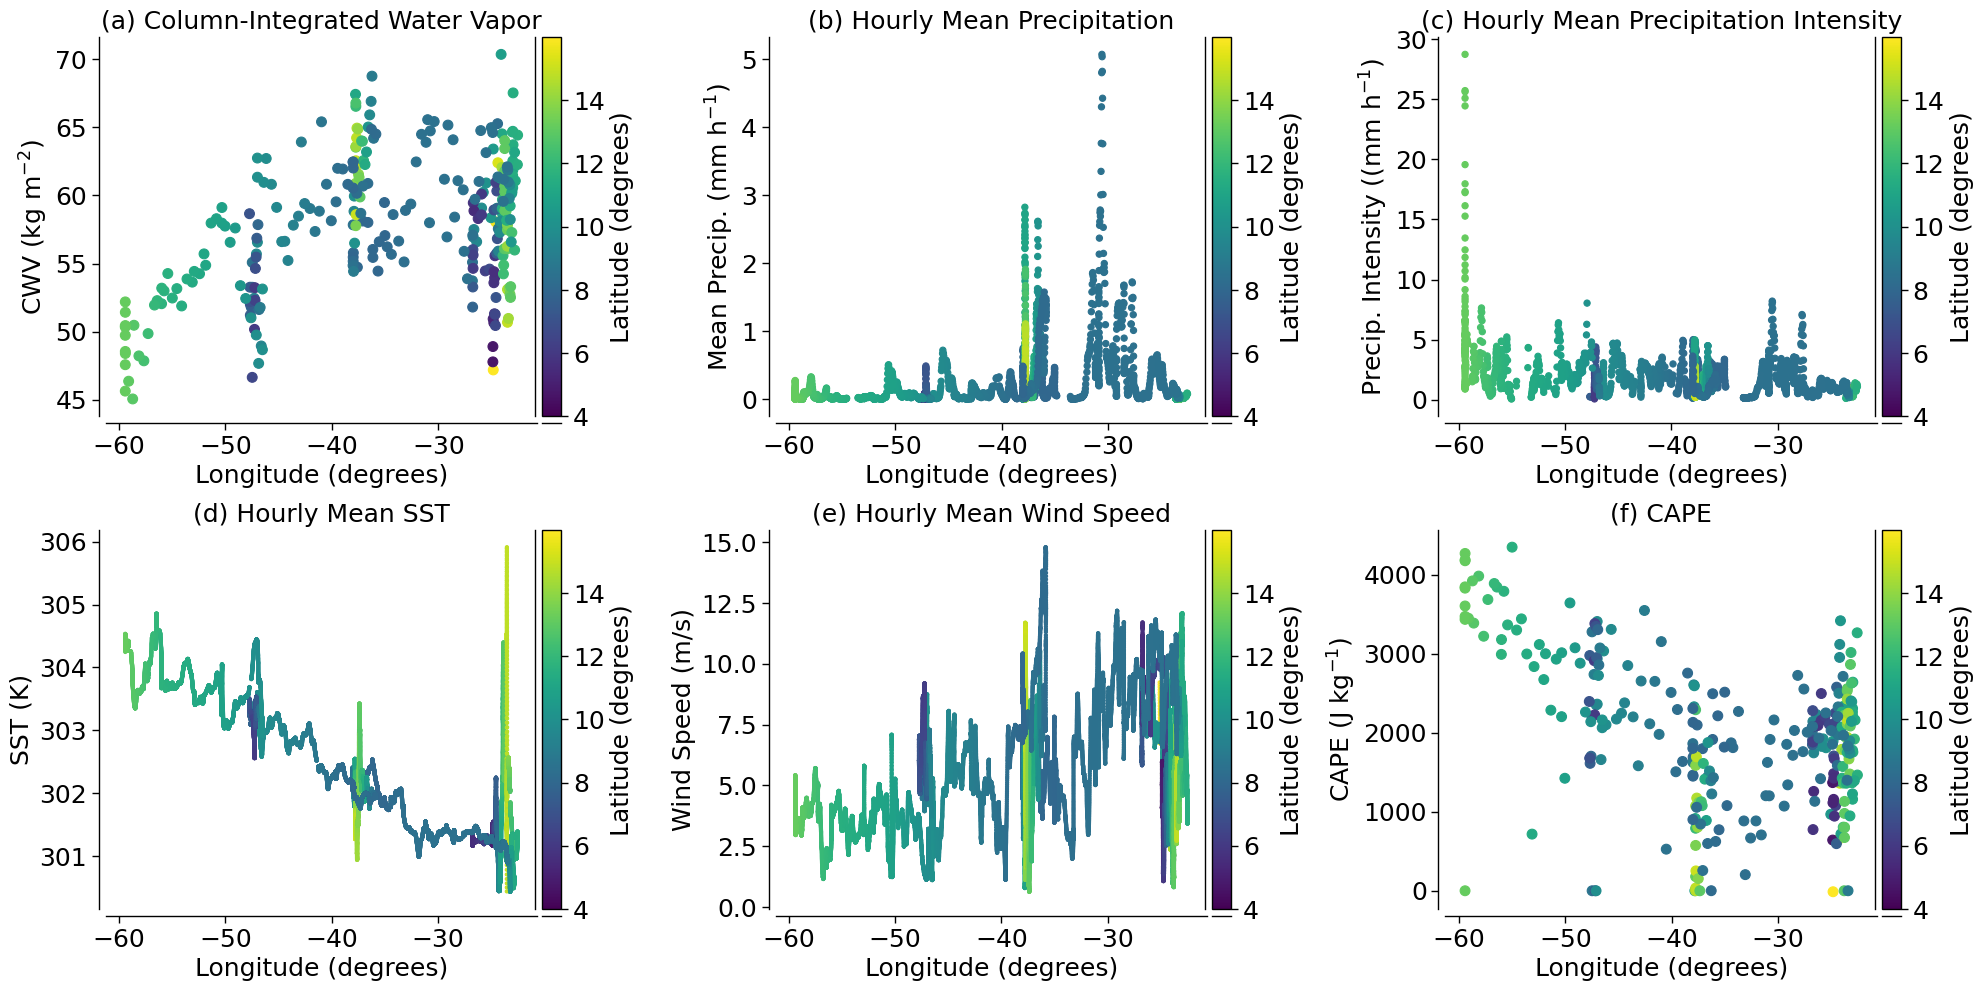

In [27]:
fig, axs = plt.subplots(2,3,figsize=(20,10))

#CWV 
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=4, vmax=16)
c = cmap(norm(sondeLAT))
axs[0,0].scatter(sondeLON,cwv,c=c,s=50,cmap='viridis',label='Latitude (degrees)')
axs[0,0].set_xlabel('Longitude (degrees)',fontsize=18)
axs[0,0].set_ylabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0,0].set_title('(a) Column-Integrated Water Vapor',fontsize=18)
axs[0,0].tick_params(labelsize=18)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,0], pad=0.01)
cbar.set_label('Latitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(4, 16, 2))
cbar.ax.set_yticklabels(np.arange(4, 16, 2))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

#precip mean
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=4, vmax=16)
c = cmap(norm(seapolLAT))
axs[0,1].scatter(seapolLON,precip,c=c,s=20,cmap='viridis',label='Latitude (degrees)')
axs[0,1].set_xlabel('Longitude (degrees)',fontsize=18)
axs[0,1].set_ylabel('Mean Precip. (mm h$^{-1}$)',fontsize=18)
axs[0,1].set_title('(b) Hourly Mean Precipitation',fontsize=18)
axs[0,1].tick_params(labelsize=18)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,1], pad=0.01)
cbar.set_label('Latitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(4, 16, 2))
cbar.ax.set_yticklabels(np.arange(4, 16, 2))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

#precip intensity
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=4, vmax=16)
c = cmap(norm(seapolLAT))
axs[0,2].scatter(seapolLON,precipint,c=c,s=20,cmap='viridis',label='Latitude (degrees)')
axs[0,2].set_xlabel('Longitude (degrees)',fontsize=18)
axs[0,2].set_ylabel('Precip. Intensity ((mm h$^{-1}$)',fontsize=18)
axs[0,2].set_title('(c) Hourly Mean Precipitation Intensity',fontsize=18)
axs[0,2].tick_params(labelsize=18)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,2], pad=0.01)
cbar.set_label('Latitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(4, 16, 2))
cbar.ax.set_yticklabels(np.arange(4, 16, 2))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

#SST
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=4, vmax=16)
c = cmap(norm(snake.LATITUDE))
axs[1,0].scatter(snake.LONGITUDE,sst_smoothed,c=c, s=5, cmap='viridis',label='Latitude (degrees)')
axs[1,0].set_xlabel('Longitude (degrees)',fontsize=18)
axs[1,0].set_ylabel('SST (K)',fontsize=18)
axs[1,0].set_title('(d) Hourly Mean SST',fontsize=18)
axs[1,0].tick_params(labelsize=18)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,0], pad=0.01)
cbar.set_label('Latitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(4, 16, 2))
cbar.ax.set_yticklabels(np.arange(4, 16, 2))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

#ship wind speed
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=4, vmax=16)
c = cmap(norm(shipLAT))
axs[1,1].scatter(shipLON,wspd_smoothed,c=c, s=5, cmap='viridis',label='Latitude (degrees)')
axs[1,1].set_xlabel('Longitude (degrees)',fontsize=18)
axs[1,1].set_ylabel('Wind Speed (m/s)',fontsize=18)
axs[1,1].set_title('(e) Hourly Mean Wind Speed',fontsize=18)
axs[1,1].tick_params(labelsize=18)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,1], pad=0.01)
cbar.set_label('Latitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(4, 16, 2))
cbar.ax.set_yticklabels(np.arange(4, 16, 2))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

#CAPE
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=4, vmax=16)
c = cmap(norm(sondeLAT))
axs[1,2].scatter(sondeLON,cape,c=c,s=50,cmap='viridis',label='Latitude (degrees)')
axs[1,2].set_xlabel('Longitude (degrees)',fontsize=18)
axs[1,2].set_ylabel('CAPE (J kg$^{-1}$)',fontsize=18)
axs[1,2].set_title('(f) CAPE',fontsize=18)
axs[1,2].tick_params(labelsize=18)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,2], pad=0.01)
cbar.set_label('Latitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(4, 16, 2))
cbar.ax.set_yticklabels(np.arange(4, 16, 2))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.


/tmp/ipykernel_2342696/3089872668.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0,0].scatter(sondeLAT,cwv,c=c,s=50,cmap='viridis',label='Longitude (degrees)')
/tmp/ipykernel_2342696/3089872668.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0,1].scatter(seapolLAT,precip,c=c,s=20,cmap='viridis',label='Longitude (degrees)')
/tmp/ipykernel_2342696/3089872668.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0,2].scatter(seapolLAT,precipint,c=c,s=20,cmap='viridis',label='Longitude (degrees)')
/tmp/ipykernel_2342696/3089872668.py:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[1,0].scatter(snake.LATITUDE,sst_smoothed,c=c, s=5, cmap='viridis',label='Longitude (degrees)')
/tmp/ipykernel_2342696/3089872668.py:84: UserWarning: No data for colormapping provided via 'c'. Parameters 'c

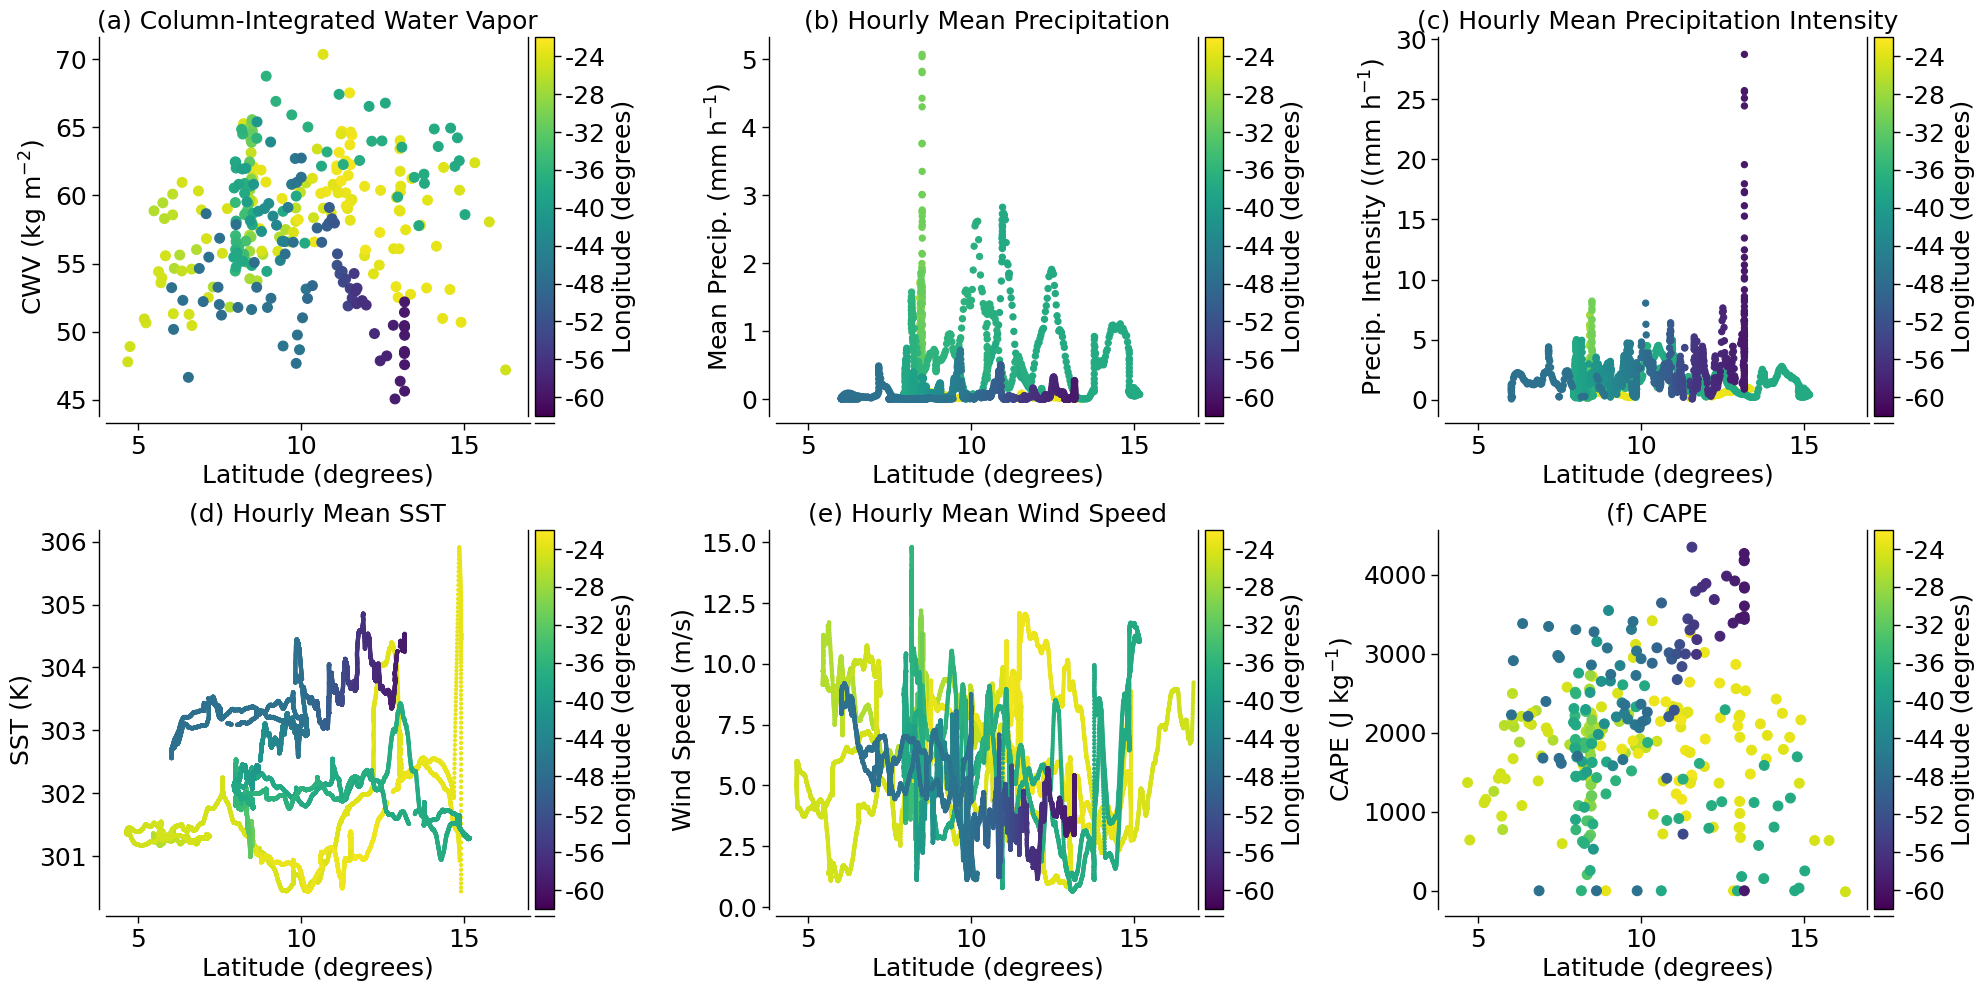

In [31]:
fig, axs = plt.subplots(2,3,figsize=(20,10))

#CWV 
#color by longitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=-62, vmax=-22)
c = cmap(norm(sondeLON))
axs[0,0].scatter(sondeLAT,cwv,c=c,s=50,cmap='viridis',label='Longitude (degrees)')
axs[0,0].set_xlabel('Latitude (degrees)',fontsize=18)
axs[0,0].set_ylabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0,0].set_title('(a) Column-Integrated Water Vapor',fontsize=18)
axs[0,0].tick_params(labelsize=18)
axs[0,0].set_xlim(4, 17)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,0], pad=0.01)
cbar.set_label('Longitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(-60, -22, 4))
cbar.ax.set_yticklabels(np.arange(-60, -22, 4))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

#precip mean
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=-62, vmax=-22)
c = cmap(norm(seapolLON))
axs[0,1].scatter(seapolLAT,precip,c=c,s=20,cmap='viridis',label='Longitude (degrees)')
axs[0,1].set_xlabel('Latitude (degrees)',fontsize=18)
axs[0,1].set_ylabel('Mean Precip. (mm h$^{-1}$)',fontsize=18)
axs[0,1].set_title('(b) Hourly Mean Precipitation',fontsize=18)
axs[0,1].tick_params(labelsize=18)
axs[0,1].set_xlim(4, 17)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,1], pad=0.01)
cbar.set_label('Longitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(-60, -22, 4))
cbar.ax.set_yticklabels(np.arange(-60, -22, 4))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

#precip intensity
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=-62, vmax=-22)
c = cmap(norm(seapolLON))
axs[0,2].scatter(seapolLAT,precipint,c=c,s=20,cmap='viridis',label='Longitude (degrees)')
axs[0,2].set_xlabel('Latitude (degrees)',fontsize=18)
axs[0,2].set_ylabel('Precip. Intensity ((mm h$^{-1}$)',fontsize=18)
axs[0,2].set_title('(c) Hourly Mean Precipitation Intensity',fontsize=18)
axs[0,2].tick_params(labelsize=18)
axs[0,2].set_xlim(4, 17)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,2], pad=0.01)
cbar.set_label('Longitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(-60, -22, 4))
cbar.ax.set_yticklabels(np.arange(-60, -22, 4))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

#SST
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=-62, vmax=-22)
c = cmap(norm(snake.LONGITUDE))
axs[1,0].scatter(snake.LATITUDE,sst_smoothed,c=c, s=5, cmap='viridis',label='Longitude (degrees)')
axs[1,0].set_xlabel('Latitude (degrees)',fontsize=18)
axs[1,0].set_ylabel('SST (K)',fontsize=18)
axs[1,0].set_title('(d) Hourly Mean SST',fontsize=18)
axs[1,0].tick_params(labelsize=18)
axs[1,0].set_xlim(4, 17)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,0], pad=0.01)
cbar.set_label('Longitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(-60, -22, 4))
cbar.ax.set_yticklabels(np.arange(-60, -22, 4))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

#ship wind speed
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=-62, vmax=-22)
c = cmap(norm(shipLON))
axs[1,1].scatter(shipLAT,wspd_smoothed,c=c, s=5, cmap='viridis',label='Longitude (degrees)')
axs[1,1].set_xlabel('Latitude (degrees)',fontsize=18)
axs[1,1].set_ylabel('Wind Speed (m/s)',fontsize=18)
axs[1,1].set_title('(e) Hourly Mean Wind Speed',fontsize=18)
axs[1,1].tick_params(labelsize=18)
axs[1,1].set_xlim(4, 17)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,1], pad=0.01)
cbar.set_label('Longitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(-60, -22, 4))
cbar.ax.set_yticklabels(np.arange(-60, -22, 4))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

#CAPE
#color by latitude
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=-62, vmax=-22)
c = cmap(norm(sondeLON))
axs[1,2].scatter(sondeLAT,cape,c=c,s=50,cmap='viridis',label='Longitude (degrees)')
axs[1,2].set_xlabel('Latitude (degrees)',fontsize=18)
axs[1,2].set_ylabel('CAPE (J kg$^{-1}$)',fontsize=18)
axs[1,2].set_title('(f) CAPE',fontsize=18)
axs[1,2].tick_params(labelsize=18)
axs[1,2].set_xlim(4, 17)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,2], pad=0.01)
cbar.set_label('Longitude (degrees)',fontsize=18)
cbar.set_ticks(np.arange(-60, -22, 4))
cbar.ax.set_yticklabels(np.arange(-60, -22, 4))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.


# examine the precip-SST-CWV relationship

In [34]:
# interpolate SST to sonde times
# Convert datetime arrays to numeric type (minutes since a reference time)
snake_time_minutes = (snake.TIME - ref_time) / np.timedelta64(1, 'm')
snake_sonde= np.interp(times_asc_minutes, snake_time_minutes, sst_smoothed)

In [79]:
# interpolate precip to sonde times
seapol_time_minutes = (seapol.time[indexAP:] - ref_time) / np.timedelta64(1, 'm')
precip_sonde = np.interp(times_asc_minutes, seapol_time_minutes, precip)
precipint_sonde = np.interp(times_asc_minutes, seapol_time_minutes, precipint)

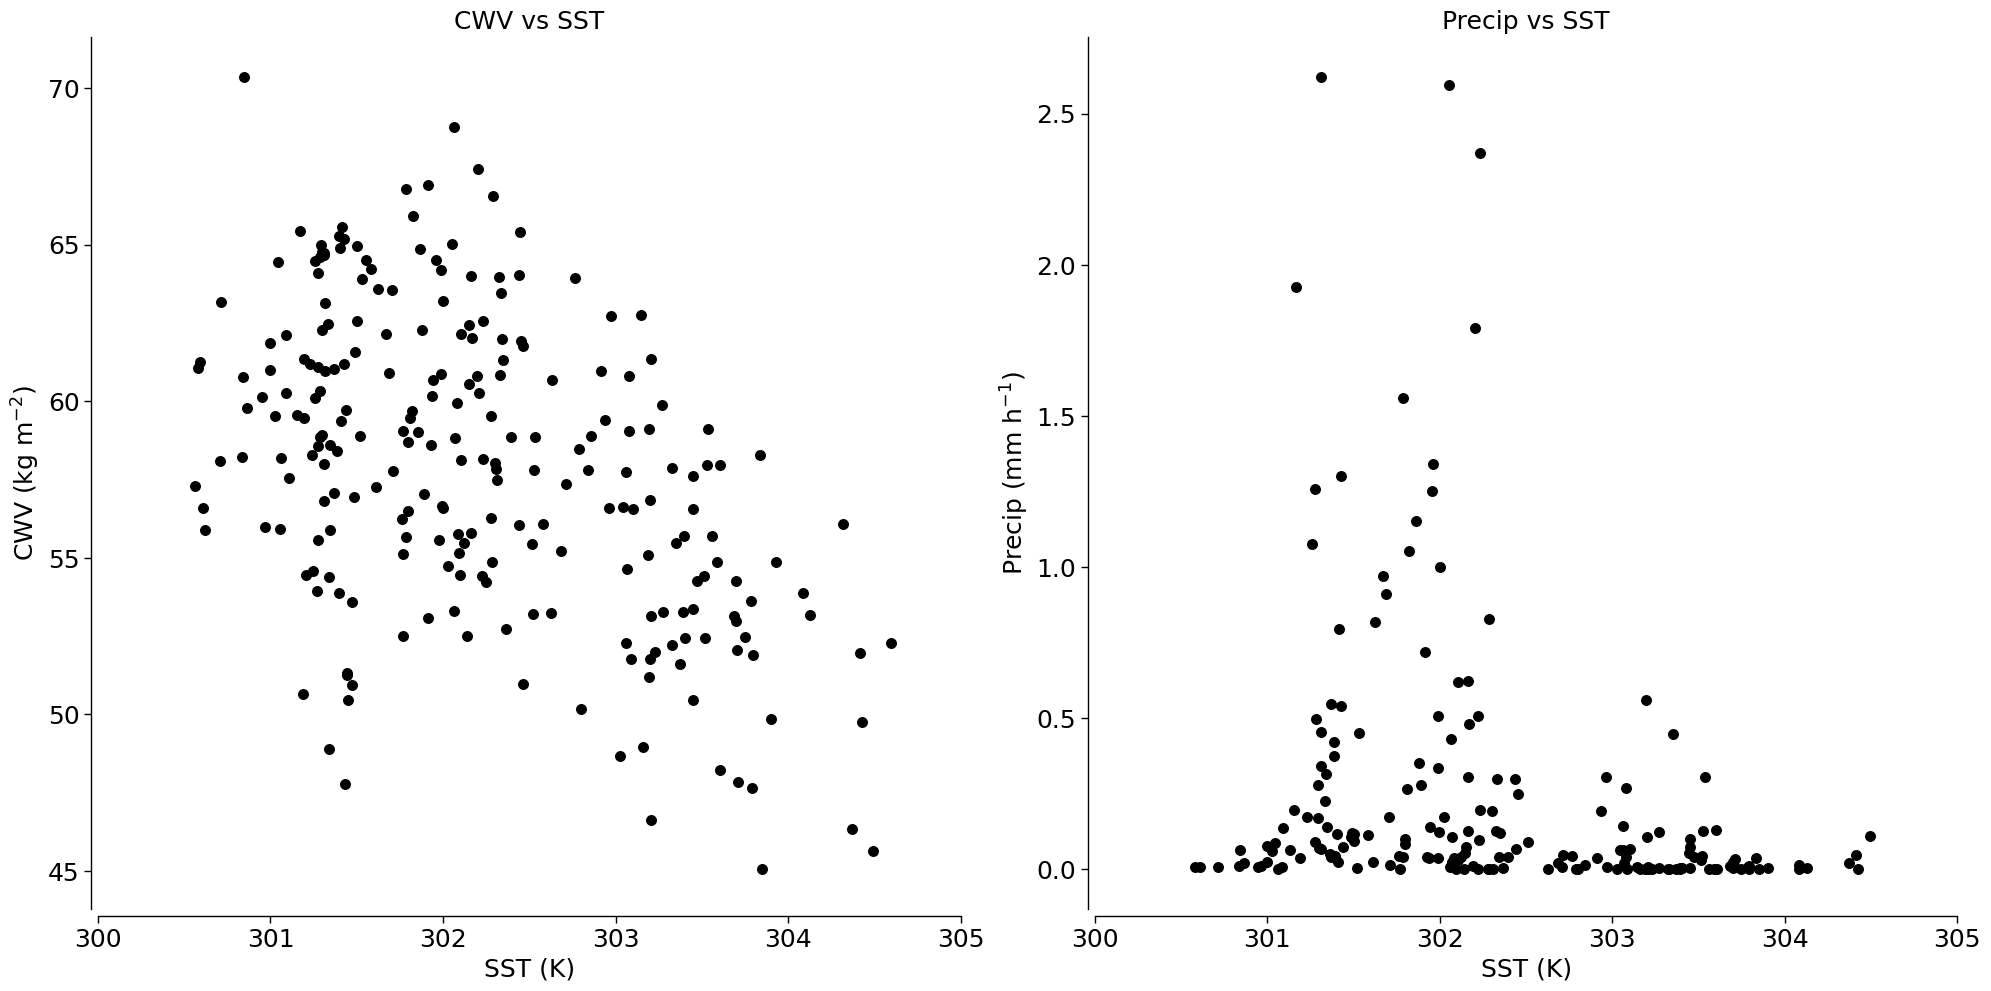

In [80]:
# plot scatter plot of precip and CWV against SST
fig, axs = plt.subplots(1,2,figsize=(20,10))
#CWV vs SST
axs[0].scatter(snake_sonde,cwv,s=50,c='k',label='CWV')
axs[0].set_xlabel('SST (K)',fontsize=18)
axs[0].set_ylabel('CWV (kg m$^{-2}$)',fontsize=18)
axs[0].set_title('CWV vs SST',fontsize=18)
axs[0].tick_params(labelsize=18)
axs[0].set_xlim(300, 305)

#Precip vs SST
axs[1].scatter(snake_sonde,precip_sonde,s=50,c='k',label='Precip')
axs[1].set_xlabel('SST (K)',fontsize=18)
axs[1].set_ylabel('Precip (mm h$^{-1}$)',fontsize=18)
axs[1].set_title('Precip vs SST',fontsize=18)
axs[1].tick_params(labelsize=18)
axs[1].set_xlim(300, 305)

sns.set_context('paper')
sns.despine(offset=5)
plt.tight_layout()  # Adjust subplots to fit into figure area.

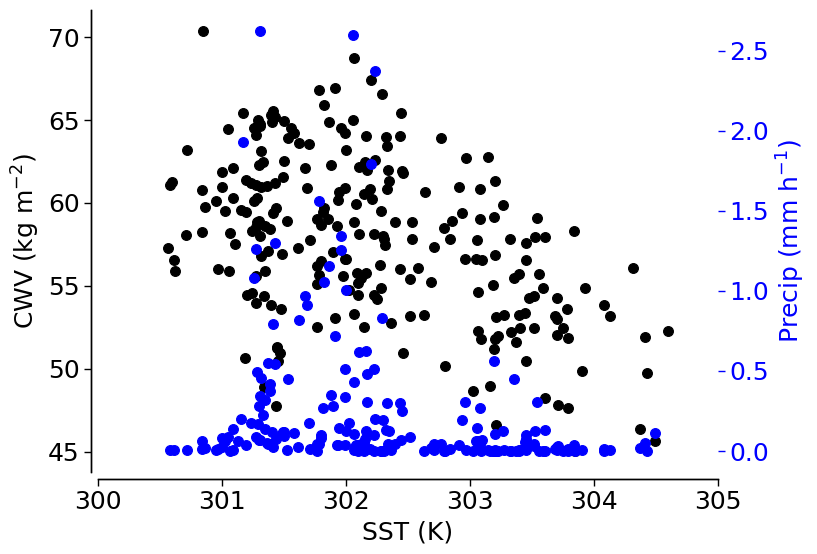

In [81]:
# plot scatter plot of precip and CWV against SST
fig, axs = plt.subplots(figsize=(8,6))
#CWV vs SST
axs.scatter(snake_sonde,cwv,s=50,c='k',label='CWV')
axs.set_xlabel('SST (K)',fontsize=18)
axs.set_ylabel('CWV (kg m$^{-2}$)',fontsize=18)
axs.tick_params(labelsize=18)
axs.set_xlim(300, 305)

#Precip vs SST
#twin y-axis
ax2 = axs.twinx()
ax2.scatter(snake_sonde,precip_sonde,s=50,c='b',label='Precip')
ax2.set_ylabel('Precip (mm h$^{-1}$)',fontsize=18,color='b')
ax2.tick_params(labelsize=18,colors='b')

sns.set_context('paper')
sns.despine(offset=5)


/tmp/ipykernel_2342696/3496009687.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs.scatter(cwv,precip_sonde,c=c,s=50,cmap='viridis',label='SST (K)')


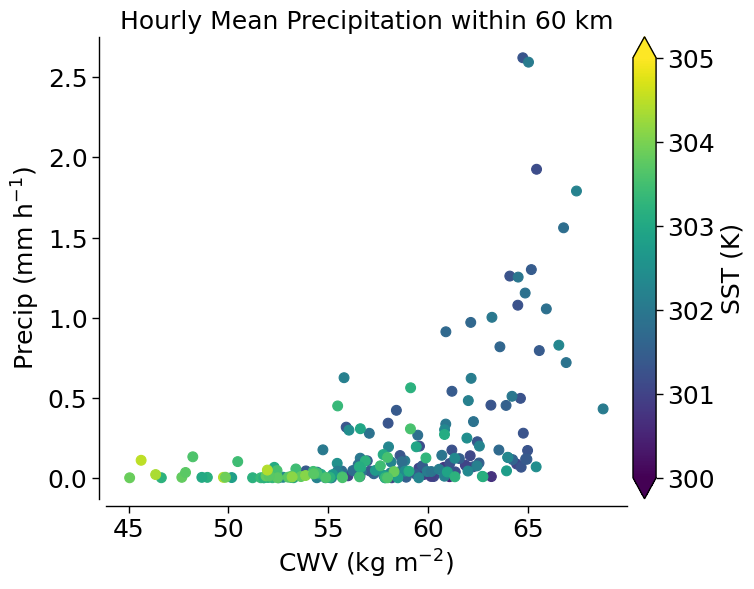

In [82]:
# plot scatter plot of precip vs CWV, colored by SST
fig, axs = plt.subplots(figsize=(8,6))

#color by SST
cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=300, vmax=305)
c = cmap(norm(snake_sonde))
axs.scatter(cwv,precip_sonde,c=c,s=50,cmap='viridis',label='SST (K)')
axs.set_xlabel('CWV (kg m$^{-2}$)',fontsize=18)
axs.set_ylabel('Precip (mm h$^{-1}$)',fontsize=18)
axs.set_title('Hourly Mean Precipitation within 60 km',fontsize=18)
axs.tick_params(labelsize=18)

sns.set_context('paper')
sns.despine(offset=5)

#colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, pad=0.01,extend='both')
cbar.set_label('SST (K)',fontsize=18)
cbar.set_ticks(np.arange(300, 306, 1))
cbar.ax.set_yticklabels(np.arange(300, 306, 1))  # Set the tick labels
cbar.ax.tick_params(labelsize=18) 
